In [46]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable

# Mô phỏng hệ sinh thái các thực thể tài chính

> **Keywords**: Graph, systemic risk

## 1. Cơ sở lý thuyết

### 1.1. Hệ thống tài chính

Hệ thống ngân hàng trong nền kinh tế hiện đại đóng vai trò trung gian tài chính then chốt, đảm bảo quá trình luân chuyển vốn và thanh khoản. Tuy nhiên, do đặc tính liên thông chặt chẽ thông qua các quan hệ vay mượn, đầu tư chéo và hợp đồng phái sinh, bản thân hệ thống cũng mang tính dễ tổn thương nội sinh. Theo lý thuyết rủi ro hệ thống (systemic risk), sự sụp đổ của một tổ chức tài chính đơn lẻ có thể gây ra hiệu ứng dây chuyền, dẫn đến mất ổn định toàn hệ thống (Allen & Gale, 2000; Haldane & May, 2011).

Khủng hoảng tài chính toàn cầu năm 2007–2008 là minh chứng rõ ràng: những cú sốc ban đầu tại thị trường bất động sản Hoa Kỳ nhanh chóng lan sang các ngân hàng và tổ chức tài chính lớn trên thế giới, gây ra hiệu ứng “too interconnected to fail”. Trong bối cảnh đó, nhiều nghiên cứu đã sử dụng khung lý thuyết mạng lưới phức hợp (complex networks) để phân tích cách rủi ro lan truyền qua các kết nối tài chính (Battiston et al., 2012; Acemoglu et al., 2015). Các nghiên cứu này chỉ ra rằng cấu trúc mạng – chẳng hạn mật độ kết nối, sự tập trung vào một số nút trung tâm (hubs) – có ảnh hưởng quyết định đến khả năng lan truyền và khuếch đại cú sốc.

Việc xây dựng mô hình mô phỏng rủi ro lan truyền trong mạng lưới ngân hàng vì thế có ý nghĩa quan trọng cả về mặt học thuật lẫn thực tiễn. Về mặt lý thuyết, nó cung cấp công cụ để hiểu rõ động lực của rủi ro hệ thống và kiểm chứng các giả thuyết về khả năng ổn định nội sinh. Về mặt chính sách, mô phỏng cho phép cơ quan quản lý đánh giá mức độ dễ tổn thương của hệ thống, từ đó đề xuất các biện pháp giảm thiểu rủi ro như yêu cầu dự trữ bắt buộc, giới hạn kết nối, hay cơ chế can thiệp sớm.

### 1.2. Lý thuyết đồ thị (graph theory)

**Đồ thị (Graph)** là một cấu trúc toán học được định nghĩa bởi một tập hợp **nút (vertices/nodes)** và **cạnh (edges)** nối giữa các nút.  
Một đồ thị có thể ký hiệu là:  

$$
G = (V, E)
$$

Trong đó:  
- $V = \{v_1, v_2, \dots, v_n\} $: tập hợp các nút.  
- $ E \subseteq V \times V $: tập hợp các cạnh nối giữa các cặp nút.  

Cạnh có thể **có hướng (directed graph)** hoặc **không hướng (undirected graph)**.  
Trong nhiều ứng dụng tài chính, cạnh còn được gán **trọng số (weight)** để phản ánh mức độ quan hệ, ví dụ như số tiền cho vay hoặc mức độ phụ thuộc. 


## 02. Xây dựng mô hình

### 2.1. Giả định hệ thống

Chúng ta giả định một hệ thống tài chính nhỏ, khép kín và có mức độ hội nhập cao, bao gồm sáu (06) định chế tài chính (ngân hàng). Thị trường đang trong giai đoạn tương đối ổn định nhưng tiềm ẩn nhiều biến động do các yếu tố vĩ mô chưa chắc chắn.

Mạng lưới liên kết giữa các ngân hàng là một đồ thị có hướng đầy đủ (fully connected), phản ánh một thị trường liên ngân hàng phát triển cao độ, nơi mỗi ngân hàng đều có quan hệ cho vay hoặc đi vay với tất cả các ngân hàng còn lại. Mối quan hệ này là bất đối xứng, nghĩa là mức độ ảnh hưởng của ngân hàng A lên ngân hàng B `(w(A->B))` không nhất thiết bằng mức độ ảnh hưởng ngược lại `(w(B->A))`.

Mô hình vận hành dựa trên các ràng buộc và giả định cốt lõi sau:

* **Hệ thống khép kín:** Mô phỏng không xem xét các yếu tố bên ngoài như sự can thiệp của ngân hàng trung ương, các cú sốc từ thị trường quốc tế, hay việc chính phủ giải cứu các định chế tài chính.
* **Kênh lan truyền duy nhất:** Rủi ro được lan truyền **duy nhất** qua kênh nợ liên ngân hàng. Trọng số `w_ij` trên các cạnh của đồ thị biểu thị mức độ nhạy cảm của phương sai rủi ro tại ngân hàng `i` đối với phương sai rủi ro tại ngân hàng `j`.
* **Bản chất của rủi ro:** "Rủi ro" là một đại lượng tổng hợp, biểu thị cho sự bất ổn và khả năng thua lỗ của một ngân hàng. Mức rủi ro ban đầu (`initial_risk = 1.0`) đại diện cho trạng thái hoạt động bình thường.
* **Cơ chế GARCH mở rộng:** Động lực học của rủi ro tuân theo mô hình GARCH (1,1) được mở rộng với thành phần lan truyền mạng lưới.
    * **Omega ($\omega$):** Đại diện cho mức rủi ro nền nội tại, dài hạn của mỗi ngân hàng.
    * **Alpha ($\alpha$):** Đo lường mức độ phản ứng của rủi ro trước các "cú sốc" (biến động bất thường) trong quá khứ gần.
    * **Beta ($\beta$):** Đại diện cho "trí nhớ" của rủi ro, thể hiện mức độ mà sự bất ổn trong quá khứ tiếp tục ảnh hưởng đến hiện tại.
* **Hành vi không đổi:** Giả định rằng các ngân hàng không thay đổi hành vi (ví dụ: cắt giảm hạn mức tín dụng, bán tháo tài sản) để phản ứng với sự gia tăng rủi ro trong suốt quá trình mô phỏng. Sự lan truyền hoàn toàn tuân theo công thức toán học đã định.

### 2.2. Hệ thống mô phỏng

#### 2.2.1. Khởi tạo đồ thị và trực quan hóa  

Bước đầu tiên trong quá trình mô phỏng là xây dựng cấu trúc đồ thị $G = (V, E)$ nhằm biểu diễn hệ thống ngân hàng.  

- Mỗi nút $v_i \in V$ đại diện cho một ngân hàng.  
- Mỗi cạnh $e_{ij} \in E$ phản ánh mối quan hệ vay nợ hoặc sự phụ thuộc tài chính giữa hai ngân hàng $i$ và $j$.  
- Các cạnh có thể mang trọng số $w_{ij}$, biểu thị cường độ quan hệ (ví dụ: giá trị khoản vay).  

Sau khi khởi tạo, đồ thị được trực quan hóa để cung cấp cái nhìn trực quan về cấu trúc liên kết của hệ thống. Việc trực quan hóa không chỉ giúp kiểm tra tính đúng đắn của mô hình mà còn hỗ trợ phân tích các đặc trưng như mật độ kết nối, vị trí trung tâm của các nút, hay sự tồn tại của các cụm ngân hàng có liên kết chặt chẽ.  

Trong triển khai thực nghiệm, việc xây dựng và trực quan hóa đồ thị được thực hiện bằng thư viện `NetworkX` kết hợp với `Matplotlib` trong Python.  

In [47]:
def init_graph(n, m, node_weights, edges):
    """
    Khởi tạo đồ thị có trọng số node và cạnh.
    
    Parameters
    ----------
    n : int
        Số lượng node
    m : int
        Số lượng cạnh
    node_weights : list[float]
        Trọng số gán cho từng node (len = n)
    edges : list[tuple]
        Danh sách các cạnh dưới dạng (u, v, w) với w là trọng số cạnh
    
    Returns
    -------
    G : networkx.Graph
        Đồ thị đã khởi tạo
    """
    G = nx.Graph()
    
    # Thêm node với trọng số
    for i in range(n):
        G.add_node(i, weight=node_weights[i])
    
    # Thêm cạnh với trọng số
    for u, v, w in edges:
        G.add_edge(u, v, weight=w)
    
    return G

In [97]:
def draw_graph(A, x_t, pos=None, risk_threshold=5.0, day=0):
    """
    Vẽ đồ thị từ ma trận kề và vector rủi ro hiện tại, có colorbar.
    
    *** PHIÊN BẢN CẬP NHẬT ***
    - Sửa lỗi `tostring_rgb` cho matplotlib phiên bản mới.
    - Thêm tham số `risk_threshold` để cố định thang màu, giúp so sánh
      giữa các frame nhất quán hơn. Màu đỏ đậm nhất ứng với ngưỡng này.
    """
    n = A.shape[0]
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)

    # Gán mức rủi ro cho các node
    for i in range(n):
        G.nodes[i]['risk'] = float(x_t[i])

    # Giữ nguyên layout giữa các frame
    if pos is None:
        pos = nx.spring_layout(G, seed=42)

    fig, ax = plt.subplots(figsize=(10, 8))

    # --- THAY ĐỔI CHÍNH Ở ĐÂY ---
    # 1. Thang màu: Đỏ (cao) -> Vàng (trung bình) -> Lục (thấp)
    cmap = plt.cm.RdYlGn_r 
    node_risks = [G.nodes[n]['risk'] for n in G.nodes]
    
    # 2. Cố định thang màu dựa vào ngưỡng (threshold)
    #    vmin = 0 (an toàn nhất)
    #    vmax = risk_threshold (nguy hiểm nhất)
    vmin = 0.0
    vmax = risk_threshold
    
    # Chuẩn hóa giá trị rủi ro vào khoảng [0, 1] để lấy màu
    # Dùng np.clip để giá trị không vượt ra ngoài khoảng [vmin, vmax]
    normalized_risks = (np.clip(node_risks, vmin, vmax) - vmin) / (vmax - vmin + 1e-9)
    node_colors = cmap(normalized_risks)
    # --- KẾT THÚC THAY ĐỔI ---

    # Vẽ các thành phần của đồ thị
    node_labels = {n: f"{n}\n{G.nodes[n]['risk']:.2f}" for n in G.nodes}
    edge_weights = nx.get_edge_attributes(G, 'weight')
    edge_labels = {k: f'{v:.2f}' for k, v in edge_weights.items()}

    nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=1500, ax=ax, width=1.5, edge_color='gray')
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black', ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, ax=ax)

    ax.set_title(f"Trạng thái rủi ro hệ thống (Ngưỡng cảnh báo: {vmax}), ngày thứ {day}", fontsize=16)

    # Vẽ thanh màu (Colorbar)
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Mức độ rủi ro", rotation=270, labelpad=20)

    # Chuyển ảnh vẽ sang numpy array để tạo GIF
    fig.canvas.draw()
    image_rgba = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    image_rgba = image_rgba.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    image_rgb = image_rgba[:, :, :3]
    
    plt.close(fig)
    return image_rgb, pos

#### 2.2.2. Cơ chế lan truyền rủi ro

#### 2.2.2. Cơ chế lan truyền rủi ro

##### **Công thức**:
Trong mô hình này, rủi ro tại mỗi ngân hàng **không chỉ phụ thuộc vào cú sốc riêng** của ngân hàng đó, mà còn được lan truyền qua **mạng lưới liên kết tài chính**.  

Cơ chế được mô tả bằng **một phiên bản mở rộng của GARCH**:

- **Tăng rủi ro (shock)** tại ngân hàng *i* tuân theo phân phối chuẩn:
  
  $$
  \Delta \text{risk}_i^t \sim \mathcal{N}(0, \sigma_{i,t}^2)
  $$

- **Phương sai có điều kiện** $\sigma_{i,t}^2$ được xác định như sau:

  $$
  \sigma_{i,t}^2 = \underbrace{\omega_i}_{\text{baseline}}
                 + \underbrace{\alpha_i (\Delta \text{risk}_i^{t-1})^2}_{\text{ARCH}}
                 + \underbrace{\beta_i \sigma_{i,t-1}^2}_{\text{GARCH}}
                 + \underbrace{\sum_{j \in N(i)} w_{ij}\,\sigma_{j,t-1}^2}_{\text{Lan truyền từ hàng xóm}}
  $$

Trong đó:

- $\omega_i$: thành phần cơ bản (baseline volatility) của ngân hàng *i*.  
- $\alpha_i$: hệ số phản ứng với cú sốc quá khứ (ARCH effect).  
- $\beta_i$: hệ số duy trì phương sai có điều kiện từ quá khứ (GARCH effect).  
- $w_{ij}$: trọng số cạnh từ ngân hàng *j* đến *i*, phản ánh mức độ ảnh hưởng.  
- $N(i)$: tập các ngân hàng có kết nối trực tiếp đến *i*.  

##### **Ý nghĩa:**  
- Rủi ro không chỉ là vấn đề cá nhân: Một ngân hàng có thể có các chỉ số nội tại $(\omega_i, \alpha_i, \beta_i)$ rất an toàn, nhưng vẫn có thể trở nên bất ổn nếu các đối tác của nó gặp khủng hoảng. Thành phần lan truyền chính là cầu nối cho hiệu ứng domino này.
- Mạng lưới là kênh khuếch đại: Cấu trúc liên kết của hệ thống ngân hàng đóng vai trò như một bộ khuếch đại. Một cú sốc ban đầu tưởng như nhỏ ở một vài định chế có thể nhanh chóng leo thang, gây ra rủi ro cho toàn hệ thống.

In [ ]:
def propagate_risk(G, delta_risk_prev, omega, alpha, beta, sigma_sq_prev):
    """
    Phiên bản cập nhật của hàm propagate_risk.

    - Sử dụng phương sai (sigma_sq) và tính toán lan truyền từ các cạnh đi vào.
    - Đảm bảo phương sai luôn là một số dương nhỏ để duy trì sự ổn định của mô hình.
    """
    n = len(G.nodes)
    risk = np.array([G.nodes[i]['risk'] for i in range(n)])
    
    # Ma trận kề trọng số A[i, j] là trọng số cạnh từ i -> j
    A = nx.to_numpy_array(G, weight='weight')
    A_T = A.T # A_T[i, j] là trọng số cạnh từ j -> i (cạnh đi vào i)

    # Tính phương sai mới theo GARCH mở rộng
    sigma_sq_new = np.zeros(n)
    for i in range(n):
        # Ảnh hưởng từ các node hàng xóm (cạnh đi vào i)
        neighbor_contrib = np.sum(A_T[i, :] * sigma_sq_prev)
        
        sigma_sq_new[i] = (omega[i] 
                           + alpha[i] * delta_risk_prev[i]**2 
                           + beta[i] * sigma_sq_prev[i] 
                           + neighbor_contrib)
    
    # --- THAY ĐỔI CHÍNH Ở ĐÂY ---
    # Đảm bảo phương sai không bao giờ nhỏ hơn một số dương rất nhỏ (epsilon).
    # Điều này tránh lỗi toán học (ví dụ: sqrt(số âm)) và ngăn hệ thống "chết" (khi scale=0).
    epsilon = 1e-3 
    sigma_sq_new = np.maximum(sigma_sq_new, epsilon)
    # --- KẾT THÚC THAY ĐỔI ---
    
    # Sinh cú sốc mới từ phương sai mới
    delta_risk_new = np.random.normal(loc=0, scale=np.sqrt(sigma_sq_new))
    
    # Cập nhật risk
    risk_next = risk + delta_risk_new
    
    # Tạo đồ thị mới với risk cập nhật
    G_new = G.copy()
    for i in range(n):
        G_new.nodes[i]['risk'] = float(risk_next[i])
    
    # Trả về đồ thị mới, phương sai mới và cú sốc mới (để dùng cho vòng lặp sau)
    return G_new, sigma_sq_new, delta_risk_new

#### 2.2.3. Các hàm chức năng khác

##### Tạo gif

Sau khi sinh ra chuỗi các frame từ quá trình mô phỏng, ta tiến hành ghép chúng lại thành một file ảnh động (GIF).  
Quá trình thực hiện gồm hai bước chính:  

1. **Lưu frame**: mỗi trạng thái của đồ thị (sau một bước lan truyền/shock) được vẽ và lưu dưới dạng ảnh (PNG hoặc tạm trong bộ nhớ).  
2. **Ghép ảnh thành GIF**: sử dụng thư viện `imageio` hoặc `Pillow` để nối các ảnh theo thứ tự thời gian, thiết lập tốc độ (fps/duration), và lưu dưới dạng `.gif`.  

In [99]:
def create_gif_from_images(images, save_path="output.gif", duration=500, loop=0):
    """
    Tạo GIF từ list các numpy array RGB.

    Args:
        images (list of np.array): list các frame (H,W,3), dtype float [0,1] hoặc uint8 [0,255]
        save_path (str): đường dẫn lưu GIF
        duration (int): thời gian mỗi frame (ms)
        loop (int): số lần lặp, 0 = vô hạn
    """
    pil_images = []
    for img in images:
        # Nếu ảnh float [0,1], convert sang uint8
        if img.dtype != np.uint8:
            img_uint8 = np.clip(img * 255, 0, 255).astype(np.uint8)
        else:
            img_uint8 = img
        pil_images.append(Image.fromarray(img_uint8))

    if pil_images:
        pil_images[0].save(
            save_path,
            save_all=True,
            append_images=pil_images[1:],
            duration=duration,
            loop=loop
        )
        print(f"GIF saved at {save_path}")
    else:
        print("No images to save.")

##### Trích xuất trọng số node

In [100]:
def get_node_weights(G, weight_attr="weight"):
    """
    Trích xuất trọng số node từ graph.
    
    Args:
        G (nx.Graph): Đồ thị networkx
        weight_attr (str): Tên thuộc tính trọng số node (mặc định: "weight")
    
    Returns:
        dict: {node: weight}
    """
    weights = {}
    for node, data in G.nodes(data=True):
        weights[node] = data.get(weight_attr, None)  # nếu không có thì trả về None
    return weights

## 3. Chạy mô phỏng

In [105]:
def main():
    """
    Hàm chính để chạy toàn bộ pipeline mô phỏng:
    1. Khởi tạo các tham số và mạng lưới ngân hàng.
    2. Tạo một cú sốc ban đầu vào một ngân hàng.
    3. Chạy vòng lặp mô phỏng, đồng thời lưu lại lịch sử rủi ro.
    4. Trực quan hóa mỗi bước và tạo GIF.
    5. Vẽ đồ thị đường biểu diễn lịch sử rủi ro của từng ngân hàng.
    """
    # --- 1. Cài đặt tham số mô phỏng ---
    N_NODES = 6
    SIMULATION_STEPS = 300
    GIF_PATH = "risk_propagation.gif"
    GIF_DURATION = 50
    RISK_THRESHOLD = 2.0 # Ngưỡng rủi ro cao nhất để vẽ màu đỏ

    # --- 2. Khởi tạo mạng lưới và các tham số GARCH ---
    print("🚀 Bắt đầu khởi tạo hệ thống...")
    G = nx.DiGraph()
    
    edges = [
        # Liên kết từ Ngân hàng 0
        (0, 1, 0.0474), (0, 2, 0.0892), (0, 3, 0.0151), (0, 4, 0.0712), (0, 5, 0.0551),
        # Liên kết từ Ngân hàng 1
        (1, 0, 0.0217), (1, 2, 0.0386), (1, 3, 0.0341), (1, 4, 0.0931), (1, 5, 0.0746),
        # Liên kết từ Ngân hàng 2
        (2, 0, 0.0519), (2, 1, 0.0493), (2, 3, 0.0143), (2, 4, 0.0458), (2, 5, 0.061),
        # Liên kết từ Ngân hàng 3
        (3, 0, 0.0569), (3, 1, 0.0243), (3, 2, 0.046), (3, 4, 0.0631), (3, 5, 0.0521),
        # Liên kết từ Ngân hàng 4
        (4, 0, 0.0241), (4, 1, 0.043), (4, 2, 0.0199), (4, 3, 0.0886), (4, 5, 0.02),
        # Liên kết từ Ngân hàng 5
        (5, 0, 0.0267), (5, 1, 0.0858), (5, 2, 0.0955), (5, 3, 0.064), (5, 4, 0.0622),
    ]
    
    initial_risk = 1.0
    for i in range(N_NODES):
        G.add_node(i, risk=initial_risk)
    
    G.add_weighted_edges_from(edges)
    
    np.random.seed(42)
    omega = np.random.uniform(0.005, 0.01, N_NODES)
    alpha = np.random.uniform(0.001, 0.02, N_NODES)
    beta = np.random.uniform(0.007, 0.08, N_NODES)

    # --- 3. Khởi tạo trạng thái ban đầu và tạo cú sốc ---
    sigma_sq_prev = np.copy(omega)
    delta_risk_prev = np.zeros(N_NODES)
    
    SHOCK_NODE = 0
    SHOCK_MAGNITUDE = 1.0
    delta_risk_prev[SHOCK_NODE] = SHOCK_MAGNITUDE
    G.nodes[SHOCK_NODE]['risk'] += SHOCK_MAGNITUDE
    
    print(f"🔥 Tạo cú sốc ban đầu vào Ngân hàng {SHOCK_NODE} với độ lớn {SHOCK_MAGNITUDE}.")

    # --- 4. Chạy vòng lặp mô phỏng ---
    print(f"⏳ Bắt đầu mô phỏng {SIMULATION_STEPS} bước...")
    images = []
    pos = None
    
    # MỚI: Ma trận 2 chiều để lưu lịch sử rủi ro
    # Hàng: Ngân hàng, Cột: Ngày
    risk_history = np.zeros((N_NODES, SIMULATION_STEPS))

    for step in range(SIMULATION_STEPS):
        A = nx.to_numpy_array(G)
        x_t = np.array([G.nodes[i]['risk'] for i in range(N_NODES)])
        
        # MỚI: Ghi lại vector rủi ro của ngày hôm nay vào ma trận lịch sử
        risk_history[:, step] = x_t
        
        # Vẽ trạng thái hiện tại (đã sửa lỗi cú pháp và thêm `day`)
        frame, pos = draw_graph(A, x_t,pos=pos, risk_threshold=RISK_THRESHOLD, day=step + 1)
        images.append(frame)
        
        # Cập nhật trạng thái (đã sửa tên hàm thành `propagate_risk_corrected`)
        G, sigma_sq_prev, delta_risk_prev = propagate_risk(
            G, delta_risk_prev, omega, alpha, beta, sigma_sq_prev
        )
        if (step + 1) % 10 == 0:
            print(f"  -> Đã hoàn thành bước {step + 1}/{SIMULATION_STEPS}")

    # --- 5. Tạo GIF từ các frame ---
    print("🎬 Đang tạo file GIF từ các frame đã lưu...")
    create_gif_from_images(images, save_path=GIF_PATH, duration=GIF_DURATION)

    # --- MỚI: 6. Vẽ đồ thị lịch sử rủi ro từ ma trận đã lưu ---
    print("📈 Đang vẽ đồ thị lịch sử rủi ro theo thời gian...")
    plt.figure(figsize=(15, 8))
    for i in range(N_NODES):
        # Mỗi hàng của ma trận là lịch sử của một ngân hàng
        plt.plot(risk_history[i, :], label=f'Ngân hàng {i}', lw=2)
    
    plt.title('Lịch sử lan truyền rủi ro của các ngân hàng', fontsize=16)
    plt.xlabel('Ngày (bước mô phỏng)')
    plt.ylabel('Mức độ rủi ro')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Ngân hàng')
    plt.axhline(y=RISK_THRESHOLD, color='r', linestyle='--', label=f'Ngưỡng cảnh báo ({RISK_THRESHOLD})')
    plt.legend() # Gọi lần 2 để hiển thị label của axhline
    plt.show()

🚀 Bắt đầu khởi tạo hệ thống...
🔥 Tạo cú sốc ban đầu vào Ngân hàng 0 với độ lớn 1.0.
⏳ Bắt đầu mô phỏng 300 bước...
  -> Đã hoàn thành bước 10/300
  -> Đã hoàn thành bước 20/300
  -> Đã hoàn thành bước 30/300
  -> Đã hoàn thành bước 40/300
  -> Đã hoàn thành bước 50/300
  -> Đã hoàn thành bước 60/300
  -> Đã hoàn thành bước 70/300
  -> Đã hoàn thành bước 80/300
  -> Đã hoàn thành bước 90/300
  -> Đã hoàn thành bước 100/300
  -> Đã hoàn thành bước 110/300
  -> Đã hoàn thành bước 120/300
  -> Đã hoàn thành bước 130/300
  -> Đã hoàn thành bước 140/300
  -> Đã hoàn thành bước 150/300
  -> Đã hoàn thành bước 160/300
  -> Đã hoàn thành bước 170/300
  -> Đã hoàn thành bước 180/300
  -> Đã hoàn thành bước 190/300
  -> Đã hoàn thành bước 200/300
  -> Đã hoàn thành bước 210/300
  -> Đã hoàn thành bước 220/300
  -> Đã hoàn thành bước 230/300
  -> Đã hoàn thành bước 240/300
  -> Đã hoàn thành bước 250/300
  -> Đã hoàn thành bước 260/300
  -> Đã hoàn thành bước 270/300
  -> Đã hoàn thành bước 280/30

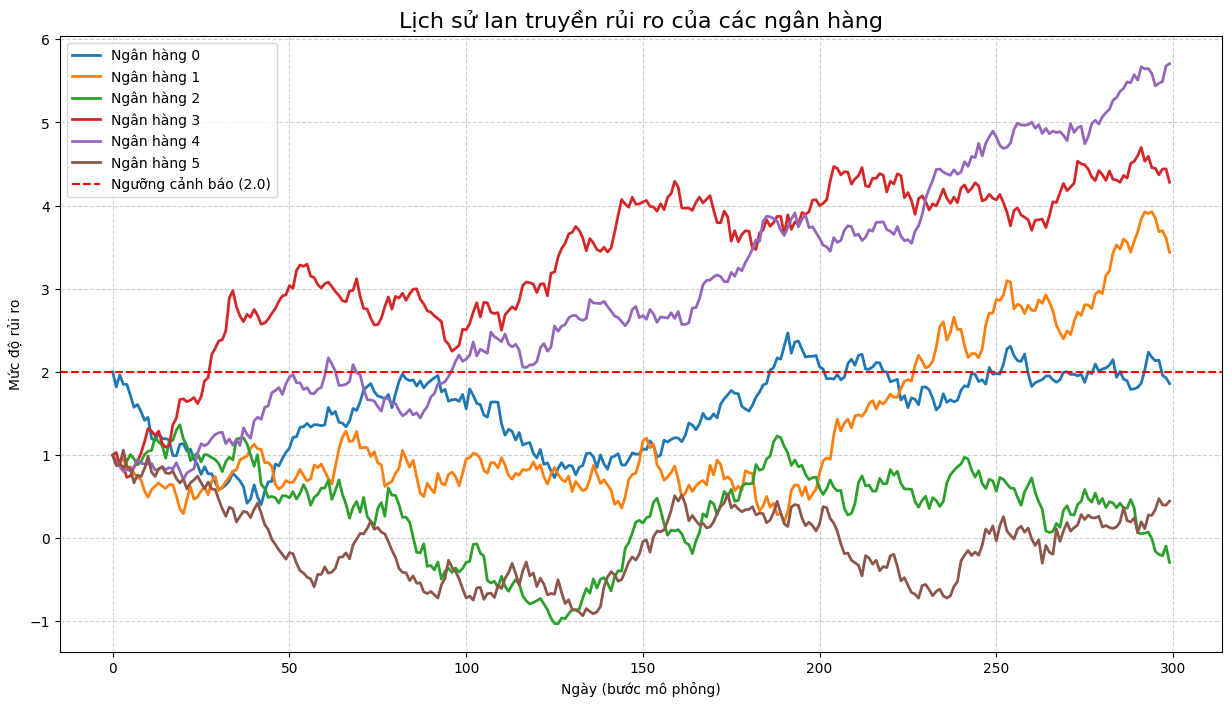

In [106]:
if __name__ == "__main__":
    main()